<div style="font-size:37px; font-weight:bold; line-height:1.1">
    Anomaly identification based on machine learning
</div>

<p style="color:rgb(90,90,90);">
The MIT License (MIT)
<br>
Copyright (c) 2018 Massachusetts Institute of Technology
</p>
<p style="color:rgb(90,90,90);">
Author: Guillaume Rongier
<br>
We acknowledge support from NSF ACI1442997 (PI: V. Pankratius) and NASA AISTNNX15AG84G (PI: V. Pankratius).
</p>
<p style="color:rgb(90,90,90);">
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
</p>
<ul style="color:rgb(90,90,90);">
<li>The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.</li>
<li>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</li>
</ul>

This notebook is part of a set of notebooks to identify anomalies, such as Earth surface deformations, in InSAR interferograms using machine learning.

Out goal here is to use two tradictional anomaly detections methods, the one-class SVM and the isolation forest, to try to identify the surface deformation due to the earthquake from noises and processing errors.

# Package imports

In [1]:
%matplotlib notebook

import math
from glob import glob
from getpass import getpass
import matplotlib.pyplot as plt

from numba import jit, prange

from skdaccess.geo.srtm.cache import DataFetcher as SRTM_DF
from skdaccess.utilities.srtm_util import merge_srtm_tiles

from pyinsar.processing.utilities.generic import sorted_alphanumeric
from pyinsar.data_import.import_raster import *
from pyinsar.data_import.import_georaster import *
from pyinsar.processing.geography.coordinates import *
from pyinsar.output.export_georaster import *
from pyinsar.output.plot_raster import *

from sklearn import svm, metrics
from sklearn.ensemble import IsolationForest

# Import the data

In [2]:
base_folder = '/data/insar/mexico_case_studies/'

case_folder = '2018_Oaxaca_Earthquake/'
anomaly_index = 10

# case_folder = '2017_Puebla_Earthquake/'
# anomaly_index = 17

data_folder = base_folder + case_folder
anomaly_folder = data_folder + 'Anomaly_Identification/'
machine_learning_folder = anomaly_folder + 'Machine_Learning/'
training_folder = machine_learning_folder + 'Training_Data/'

training_data_names = ['Stacked_Referenced_filt_topophase_unw_geo']
# training_data_names = ['Stacked_Referenced_filt_atmtopophase_unw_geo']

application_data_names = [['Stacked_Referenced_filt_topophase_unw_geo'],
                          ['Stacked_Referenced_filt_atmtopophase_unw_geo']]

In [3]:
pads = (0, 0)

slices = [[0, None], [0, None]]
for i in range(len(pads)):
    if pads[i] > 0:
        slices[i][0] = pads[i]
        slices[i][1] = -pads[i]

Training data

In [4]:
training_data_paths = []
for training_data_name in training_data_names:
    training_data_path = glob(training_folder + '*Training_' + training_data_name + '*.tif')
    training_data_path = sorted_alphanumeric(training_data_path)
    training_data_paths.append(training_data_path)
training_data_paths = list(zip(*training_data_paths))

In [5]:
training_raster = open_georaster(training_data_paths[0][0])
subarray_shape = (training_raster.RasterYSize, training_raster.RasterYSize)

In [6]:
%%time

training_size = 0
for training_data_path in training_data_paths:
    training_raster = open_georaster(training_data_path[0])
    training_size += training_raster.RasterCount
    training_raster = None

training_data_array = np.empty((training_size, subarray_shape[0], subarray_shape[1], len(training_data_names)))
current_size = 0
for training_data_path in training_data_paths:
    for i, path in enumerate(training_data_path):
        training_raster = open_georaster(path)
        training_data_array[current_size:current_size + training_raster.RasterCount, ..., i] = get_georaster_array(training_raster)
        if i + 1 == len(training_data_path):
            current_size += training_raster.RasterCount
        training_raster = None

CPU times: user 1min 24s, sys: 3.11 s, total: 1min 27s
Wall time: 12.5 s


In [7]:
training_data_array.shape

(5880, 128, 128, 1)

<IPython.core.display.Javascript object>


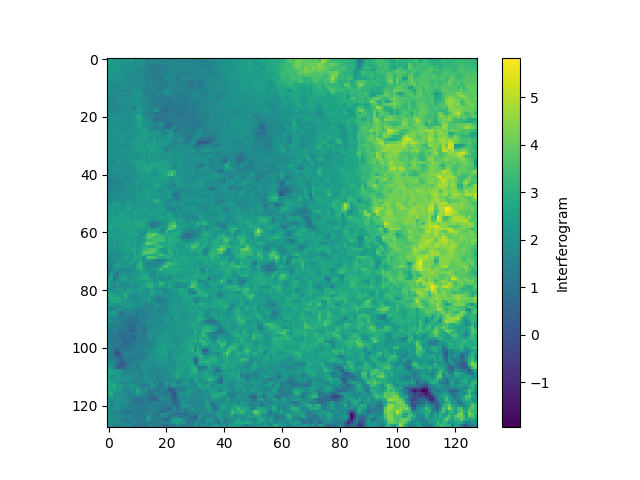

In [8]:
plot_interactive_multiple_slicing(training_data_array,
                                  [0, 3],
                                  [0, 0],
                                  update_colorbar = True,
                                  clabel = 'Interferogram')

Test data

In [9]:
test_data_paths = []
for test_data_name in training_data_names:
    test_data_path = glob(training_folder + '*Test_' + test_data_name + '*.tif')
    test_data_path = sorted_alphanumeric(test_data_path)
    test_data_paths.append(test_data_path)
test_data_paths = list(zip(*test_data_paths))

In [10]:
%%time

test_size = 0
for test_data_path in test_data_paths:
    test_raster = open_georaster(test_data_path[0])
    test_size += test_raster.RasterCount
    test_raster = None

test_data_array = np.empty((test_size, subarray_shape[0], subarray_shape[1], len(training_data_names)))
current_size = 0
for test_data_path in test_data_paths:
    for i, path in enumerate(test_data_path):
        test_raster = open_georaster(path)
        test_data_array[current_size:current_size + test_raster.RasterCount, ..., i] = get_georaster_array(test_raster)
        if i + 1 == len(test_data_path):
            current_size += test_raster.RasterCount
        test_raster = None

CPU times: user 38.9 s, sys: 1.21 s, total: 40.1 s
Wall time: 2.62 s


In [11]:
test_data_array.shape

(713, 128, 128, 1)

<IPython.core.display.Javascript object>


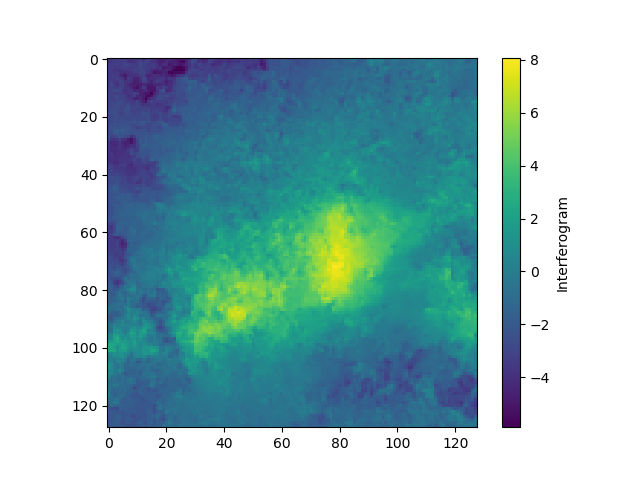

In [12]:
plot_interactive_multiple_slicing(test_data_array,
                                  [0, 3],
                                  [0, 0],
                                  update_colorbar = True,
                                  clabel = 'Interferogram')

Application case

In [13]:
%%time

georaster = open_georaster(data_folder + application_data_names[0][0] + '.tif')
application_data_array = get_georaster_array(georaster)[None, ...]
application_data_extent = np.array(get_georaster_extent(georaster))
application_data_projection = georaster.GetProjection()
application_data_spacing = (abs(georaster.GetGeoTransform()[5]), georaster.GetGeoTransform()[1])

for i in range(len(application_data_names)):
    for j in range(len(application_data_names[i])):
        if i != 0 or j != 0:
            georaster = open_georaster(data_folder + application_data_names[i][j] + '.tif')
            georaster_array = get_georaster_array(georaster)
            application_data_array = np.concatenate((application_data_array, georaster_array[None]), axis = 0)

tf_application_data_array = np.copy(application_data_array)
tf_application_data_array[np.isnan(tf_application_data_array)] = 0.
tf_application_data_array = np.moveaxis(tf_application_data_array, 1, -1)

CPU times: user 1min 31s, sys: 13.1 s, total: 1min 44s
Wall time: 51.7 s


<IPython.core.display.Javascript object>


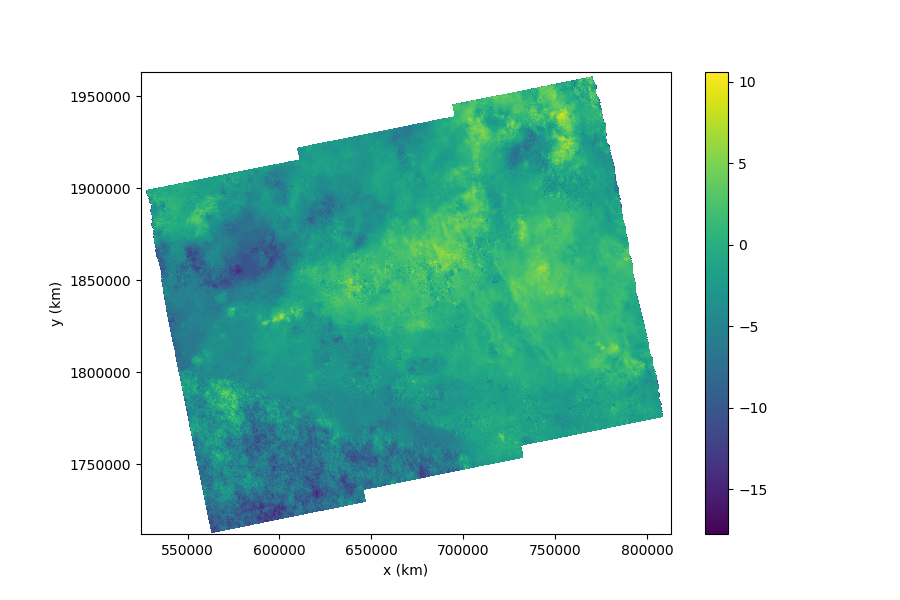

In [14]:
plot_interactive_multiple_slicing(application_data_array,
                                  [0, 1],
                                  [0, 0],
                                  update_colorbar = True,
                                  extent = application_data_extent,
                                  xlabel = 'x (km)',
                                  ylabel = 'y (km)',
                                  figsize = (9, 6))

In [15]:
%%time

tile_shape = (subarray_shape[0] - 2*pads[0], subarray_shape[1] - 2*pads[1])
is_shape_centered = False
return_subarray_indexes = True

tiles, tile_indices = sample_array(application_data_array,
                                   tile_shape,
                                   steps = tile_shape,
                                   pads = pads,
                                   is_shape_centered = is_shape_centered,
                                   return_subarray_indexes = return_subarray_indexes)
tiles = np.moveaxis(tiles, 2, -1)

CPU times: user 3.65 s, sys: 447 ms, total: 4.1 s
Wall time: 3.68 s


In [16]:
tiles.shape

(317, 2, 128, 128, 24)

In [17]:
tile_indices = np.array(tile_indices, dtype = np.float)
tile_indices[:, 0] += tile_shape[0]/2.
tile_indices[:, 1] += tile_shape[1]/2.

# One-class SVM

Train

In [18]:
%%time

oneclass_svm_model = svm.OneClassSVM(kernel = 'rbf', nu = 0.001, gamma = 1e-8, random_state = 101)
oneclass_svm_model.fit(training_data_array[:,
                                           slices[0][0]:slices[0][1],
                                           slices[1][0]:slices[1][1]].reshape(training_data_array.shape[0], -1))   

CPU times: user 1.87 s, sys: 0 ns, total: 1.87 s
Wall time: 1.86 s


In [19]:
%%time

test_predictions = oneclass_svm_model.predict(test_data_array[:,
                                                              slices[0][0]:slices[0][1],
                                                              slices[1][0]:slices[1][1]].reshape(test_data_array.shape[0], -1))  
test_targets = np.ones(test_data_array.shape[0])

print("accuracy: ", metrics.accuracy_score(test_targets, test_predictions))  
print("precision: ", metrics.precision_score(test_targets, test_predictions))  
print("recall: ", metrics.recall_score(test_targets, test_predictions))  
print("f1: ", metrics.f1_score(test_targets, test_predictions))  

accuracy:  0.9985974754558204
precision:  1.0
recall:  0.9985974754558204
f1:  0.999298245614035
CPU times: user 85.3 ms, sys: 93 µs, total: 85.4 ms
Wall time: 83.6 ms


Predict

In [20]:
%%time

oneclass_svm_predictions = [[] for i in range(tiles.shape[1])]
oneclass_svm_decisions = [[] for i in range(tiles.shape[1])]
for i in range(tiles.shape[1]):
    for j in range(tiles.shape[-1]):
        temp_oneclass_svm_predictions = oneclass_svm_model.predict(tiles[:,
                                                                         i,
                                                                         slices[0][0]:slices[0][1],
                                                                         slices[1][0]:slices[1][1],
                                                                         j].reshape(tiles.shape[0], -1))
        oneclass_svm_predictions[i].append(temp_oneclass_svm_predictions)
        temp_oneclass_svm_decisions = oneclass_svm_model.decision_function(tiles[:,
                                                                                 i,
                                                                                 slices[0][0]:slices[0][1],
                                                                                 slices[1][0]:slices[1][1],
                                                                                 j].reshape(tiles.shape[0], -1))
        oneclass_svm_decisions[i].append(temp_oneclass_svm_decisions)
          
oneclass_svm_predictions = np.array(oneclass_svm_predictions)
oneclass_svm_decisions = np.array(oneclass_svm_decisions)[..., 0]

CPU times: user 4.53 s, sys: 813 ms, total: 5.34 s
Wall time: 5.34 s


In [21]:
oneclass_svm_decisions.shape

(2, 24, 317)

In [22]:
i_type = 1

min_oneclass_svm_decisions = np.min(oneclass_svm_decisions, axis = -1)
mean_oneclass_svm_decisions = np.mean(oneclass_svm_decisions, axis = -1)
std_oneclass_svm_decisions = np.std(oneclass_svm_decisions, axis = -1)
max_oneclass_svm_decisions = np.max(oneclass_svm_decisions, axis = -1)

print('Min:', min_oneclass_svm_decisions[i_type])
print('Mean:', mean_oneclass_svm_decisions[i_type])
print('Std:', std_oneclass_svm_decisions[i_type])
print('Max:', max_oneclass_svm_decisions[i_type])

Min: [ 0.20029749  0.24630061  0.28108599  0.04653949  0.12622069  0.21262475
  0.25160856  0.25366979  0.12228743  0.2603653  -0.34079368  0.26589873
  0.26633807  0.25169501  0.23602385  0.26931373  0.20488528  0.17060795
  0.21605309  0.10460935  0.16735108  0.21918328  0.06279162  0.12111658]
Mean: [0.30308832 0.30878929 0.31065876 0.26266051 0.2591263  0.28686207
 0.30316972 0.30433288 0.24359373 0.30945519 0.27774162 0.31103045
 0.30471024 0.29499563 0.29988279 0.30756993 0.29628052 0.29359321
 0.29873412 0.27010676 0.29741392 0.2902198  0.27005734 0.27787032]
Std: [0.01646072 0.00837693 0.0050535  0.06363537 0.03442381 0.02366801
 0.01257678 0.01168498 0.03286474 0.00874263 0.08620407 0.00661917
 0.00904035 0.0131757  0.01591092 0.0074832  0.01825156 0.03203321
 0.01520629 0.03969981 0.03085782 0.01912877 0.05142626 0.04093505]
Max: [0.31550288 0.31556527 0.31548327 0.31561002 0.31161055 0.31530906
 0.31556373 0.31528521 0.30327166 0.31559303 0.31534936 0.31569161
 0.31532865 0.

<IPython.core.display.Javascript object>


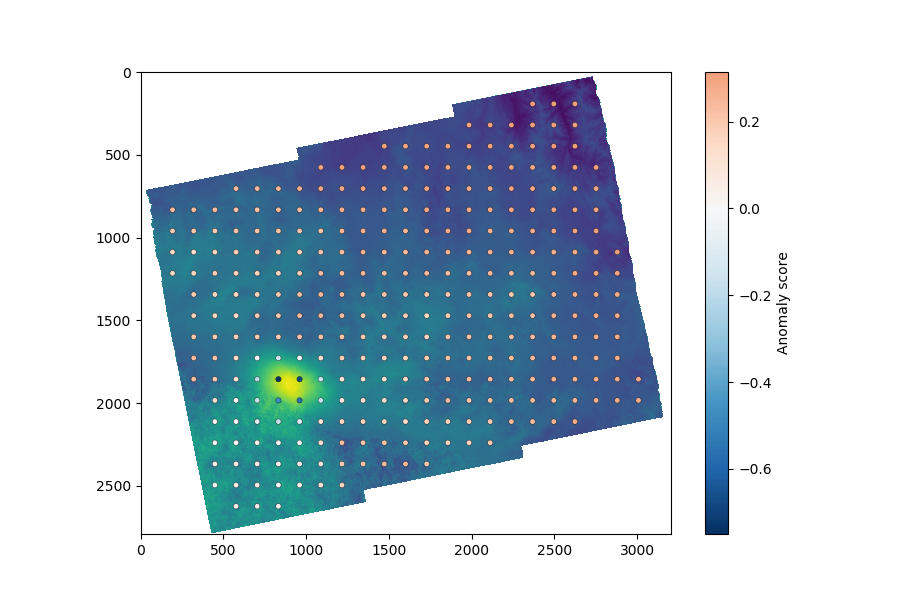

In [23]:
i_type = 0
i_image = 10

figure, subplot = plt.subplots(figsize = (9, 6))

raster_map = plt.imshow(np.ma.masked_invalid(application_data_array[i_type, i_image]),
                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)

scatter = plt.scatter(tile_indices[:, 1],
                      tile_indices[:, 0],
                      c = oneclass_svm_decisions[i_type, i_image],
                      s = 15,
                      edgecolor = 'black',
                      linewidth = 0.25,
                      cmap = 'RdBu_r', norm = MidpointNormalize())

raster_map_colorbar = plt.colorbar(scatter)
raster_map_colorbar.set_label('Anomaly score')
                
plt.show()

<IPython.core.display.Javascript object>


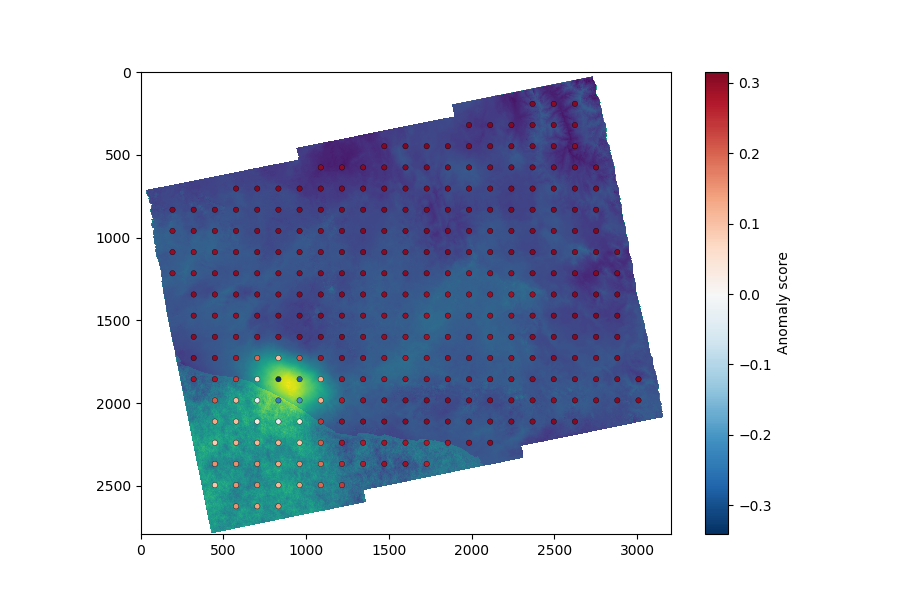

In [24]:
i_type = 1
i_image = 10

figure, subplot = plt.subplots(figsize = (9, 6))

raster_map = plt.imshow(np.ma.masked_invalid(application_data_array[i_type, i_image]),
                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)

scatter = plt.scatter(tile_indices[:, 1],
                      tile_indices[:, 0],
                      c = oneclass_svm_decisions[i_type, i_image],
                      s = 15,
                      edgecolor = 'black',
                      linewidth = 0.25,
                      cmap = 'RdBu_r', norm = MidpointNormalize())

raster_map_colorbar = plt.colorbar(scatter)
raster_map_colorbar.set_label('Anomaly score')
                
plt.show()

In [25]:
training_suffix = 'topophase'
# training_suffix = 'atmtopophase'
prediction_suffix = ['topophase', 'atmtopophase']
for i in range(oneclass_svm_decisions.shape[0]):
    for j in range(oneclass_svm_decisions.shape[1]):
        np.savetxt(anomaly_folder + 'tile_anomaly_score_training_' + training_suffix + '_prediction_' + prediction_suffix[i] + '_pair' + str(j + 1) + '_onclass_svm.csv',
                   (tile_indices[:, 1], tile_indices[:, 0], oneclass_svm_decisions[i, j]))

# Isolation Forest

Train

In [26]:
%%time

n_jobs = 5

isolation_forest_model = IsolationForest(max_samples = 'auto', contamination = 0.01, random_state = 101, n_jobs = n_jobs)
isolation_forest_model.fit(training_data_array[:,
                                               slices[0][0]:slices[0][1],
                                               slices[1][0]:slices[1][1]].reshape(training_data_array.shape[0], -1))   

CPU times: user 18.1 s, sys: 1.94 s, total: 20 s
Wall time: 3min 59s


In [27]:
%%time

test_predictions = isolation_forest_model.predict(test_data_array[:,
                                                                  slices[0][0]:slices[0][1],
                                                                  slices[1][0]:slices[1][1]].reshape(test_data_array.shape[0], -1))  
test_targets = np.ones(test_data_array.shape[0])

print("accuracy: ", metrics.accuracy_score(test_targets, test_predictions))  
print("precision: ", metrics.precision_score(test_targets, test_predictions))  
print("recall: ", metrics.recall_score(test_targets, test_predictions))  
print("f1: ", metrics.f1_score(test_targets, test_predictions))  

accuracy:  0.9831697054698457
precision:  1.0
recall:  0.9831697054698457
f1:  0.9915134370579914
CPU times: user 4.78 s, sys: 77.8 ms, total: 4.86 s
Wall time: 2.45 s


Predict

In [28]:
%%time

isolation_forest_predictions = [[] for i in range(tiles.shape[1])]
isolation_forest_decisions = [[] for i in range(tiles.shape[1])]
for i in range(tiles.shape[1]):
    for j in range(tiles.shape[-1]):
        temp_isolation_forest_predictions = isolation_forest_model.predict(tiles[:,
                                                                                 i,
                                                                                 slices[0][0]:slices[0][1],
                                                                                 slices[1][0]:slices[1][1],
                                                                                 j].reshape(tiles.shape[0], -1))
        isolation_forest_predictions[i].append(temp_isolation_forest_predictions)
        temp_isolation_forest_decisions = isolation_forest_model.decision_function(tiles[:,
                                                                                         i,
                                                                                         slices[0][0]:slices[0][1],
                                                                                         slices[1][0]:slices[1][1],
                                                                                         j].reshape(tiles.shape[0], -1))
        isolation_forest_decisions[i].append(temp_isolation_forest_decisions)
          
isolation_forest_predictions = np.array(isolation_forest_predictions)
isolation_forest_decisions = np.array(isolation_forest_decisions)

CPU times: user 3min 12s, sys: 6.71 s, total: 3min 19s
Wall time: 1min 1s


In [29]:
isolation_forest_decisions.shape

(2, 24, 317)

In [30]:
i_type = 0

min_isolation_forest_decisions = np.min(isolation_forest_decisions, axis = -1)
mean_isolation_forest_decisions = np.mean(isolation_forest_decisions, axis = -1)
std_isolation_forest_decisions = np.std(isolation_forest_decisions, axis = -1)
max_isolation_forest_decisions = np.max(isolation_forest_decisions, axis = -1)

print('Min:', min_isolation_forest_decisions[i_type])
print('Mean:', mean_isolation_forest_decisions[i_type])
print('Std:', std_isolation_forest_decisions[i_type])
print('Max:', max_isolation_forest_decisions[i_type])

Min: [-0.01402623 -0.02132732 -0.02075693 -0.20338045 -0.14887689 -0.02078708
 -0.01031735  0.0471271   0.02215438 -0.00805122 -0.20863961  0.01982159
  0.01546305 -0.10902209 -0.05579571 -0.01125768 -0.06262046 -0.18470039
 -0.08393969 -0.09146132  0.02652845 -0.0738864  -0.11452979 -0.07545408]
Mean: [ 0.0880075   0.08562837  0.07827185 -0.04232627 -0.03821008  0.08750568
  0.08616834  0.09862559  0.09183146  0.09006326  0.00394379  0.09078443
  0.10278893  0.06166143  0.06401348  0.08635818  0.06882472 -0.01510199
  0.06866472  0.07458496  0.09287898  0.07196994  0.08052631  0.04739368]
Std: [0.02796325 0.02398615 0.03135004 0.10305448 0.05074249 0.03181074
 0.03116605 0.01794112 0.01928743 0.0249859  0.09244993 0.01884773
 0.01853458 0.04330912 0.03820802 0.02085498 0.0335736  0.08942205
 0.03620359 0.03423845 0.02085265 0.02867469 0.03971804 0.04694399]
Max: [0.12620733 0.12754045 0.12560391 0.11732196 0.09082241 0.12826666
 0.12627111 0.12655035 0.12788936 0.12677155 0.11145792 0

<IPython.core.display.Javascript object>


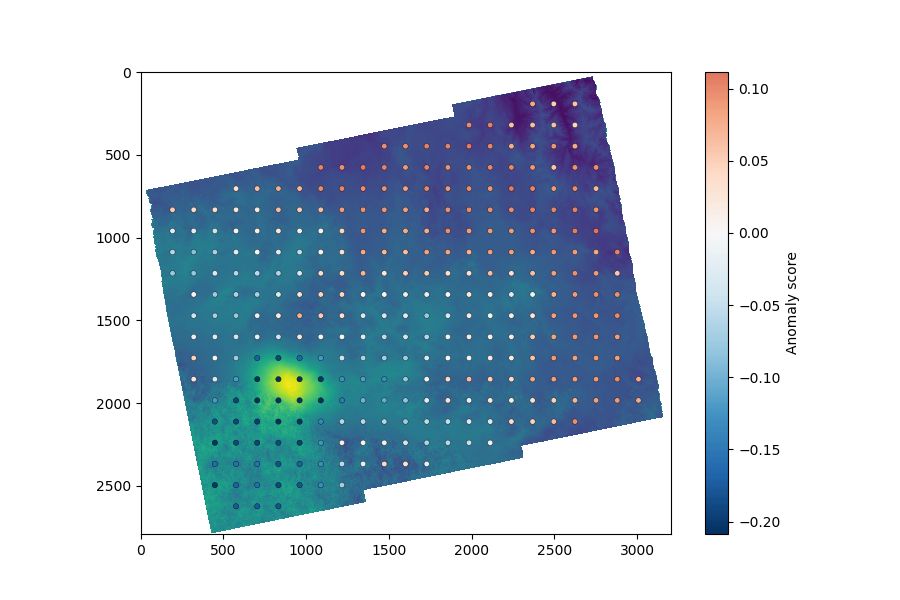

In [31]:
i_type = 0
i_image = 10

figure, subplot = plt.subplots(figsize = (9, 6))

raster_map = plt.imshow(np.ma.masked_invalid(application_data_array[i_type, i_image]),
                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)

scatter = plt.scatter(tile_indices[:, 1],
                      tile_indices[:, 0],
                      c = isolation_forest_decisions[i_type, i_image],
                      s = 15,
                      edgecolor = 'black',
                      linewidth = 0.25,
                      cmap = 'RdBu_r', norm = MidpointNormalize())

raster_map_colorbar = plt.colorbar(scatter)
raster_map_colorbar.set_label('Anomaly score')
                
plt.show()

<IPython.core.display.Javascript object>


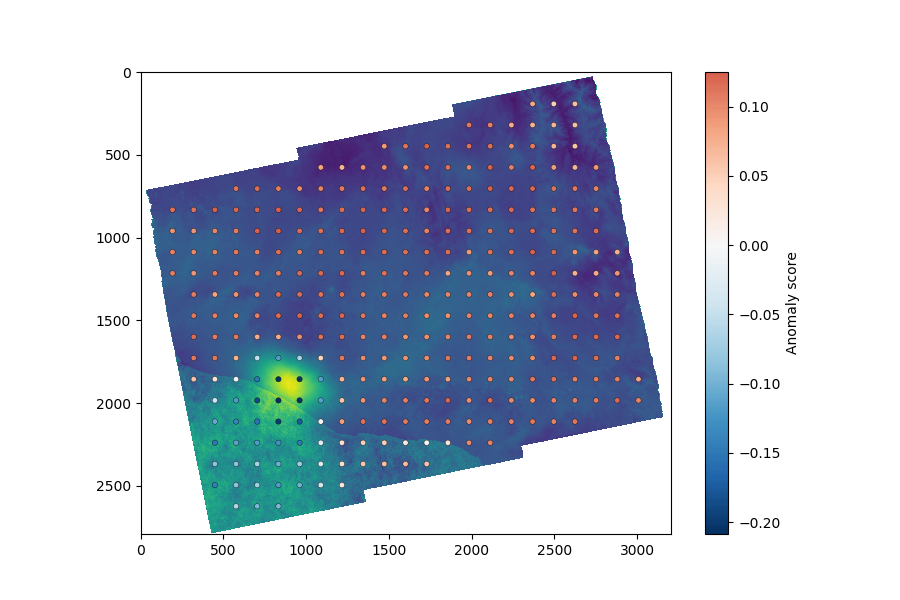

In [32]:
i_type = 1
i_image = 10

figure, subplot = plt.subplots(figsize = (9, 6))

raster_map = plt.imshow(np.ma.masked_invalid(application_data_array[i_type, i_image]),
                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)

scatter = plt.scatter(tile_indices[:, 1],
                      tile_indices[:, 0],
                      c = isolation_forest_decisions[i_type, i_image],
                      s = 15,
                      edgecolor = 'black',
                      linewidth = 0.25,
                      cmap = 'RdBu_r', norm = MidpointNormalize())

raster_map_colorbar = plt.colorbar(scatter)
raster_map_colorbar.set_label('Anomaly score')
                
plt.show()

In [33]:
training_suffix = 'topophase'
# training_suffix = 'atmtopophase'
prediction_suffix = ['topophase', 'atmtopophase']
for i in range(isolation_forest_decisions.shape[0]):
    for j in range(isolation_forest_decisions.shape[1]):
        np.savetxt(anomaly_folder + 'tile_anomaly_score_training_' + training_suffix + '_prediction_' + prediction_suffix[i] + '_pair' + str(j + 1) + '_isolation_forest.csv',
                   (tile_indices[:, 1], tile_indices[:, 0], isolation_forest_decisions[i, j]))